In [1]:
%load_ext rpy2.ipython
%matplotlib inline
from prophet import Prophet
from matplotlib import pyplot as plt

import pandas as pd
import logging
import warnings

logging.getLogger('prophet').setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

In [7]:
df = pd.read_csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=366)

from prophet.diagnostics import cross_validation
df_cv = cross_validation(
    m, '365 days', initial='1825 days', period='365 days')
cutoff = df_cv['cutoff'].unique()[0]
df_cv = df_cv[df_cv['cutoff'].values == cutoff]

19:38:36 - cmdstanpy - INFO - Chain [1] start processing
19:38:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

19:38:37 - cmdstanpy - INFO - Chain [1] start processing
19:38:37 - cmdstanpy - INFO - Chain [1] done processing
19:38:37 - cmdstanpy - INFO - Chain [1] start processing
19:38:37 - cmdstanpy - INFO - Chain [1] done processing
19:38:38 - cmdstanpy - INFO - Chain [1] start processing
19:38:38 - cmdstanpy - INFO - Chain [1] done processing


In [8]:
%%R
library(prophet)
df <- read.csv('https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv')
m <- prophet(df)
future <- make_future_dataframe(m, periods=366)

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.


### Cross validation

Prophet includes functionality for time series cross validation to measure forecast error using historical data. This is done by selecting cutoff points in the history, and for each of them fitting the model using data only up to that cutoff point. We can then compare the forecasted values to the actual values. This figure illustrates a simulated historical forecast on the Peyton Manning dataset, where the model was fit to an initial history of 5 years, and a forecast was made on a one year horizon.

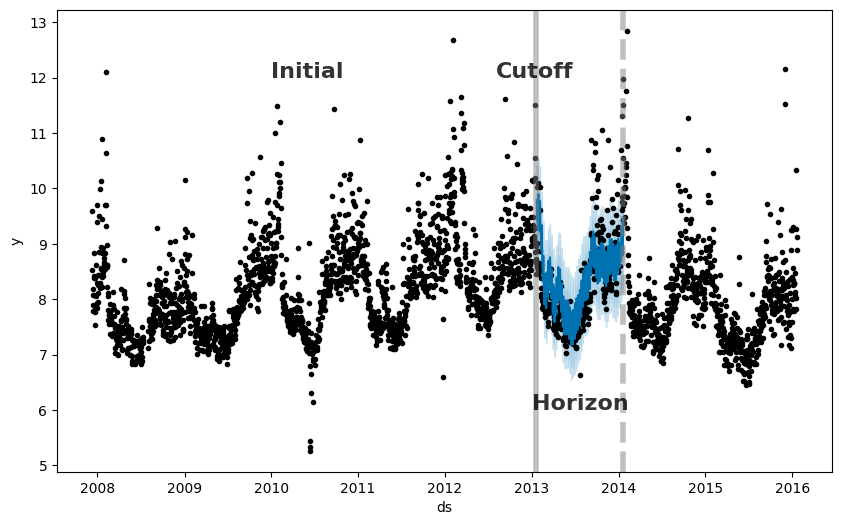

In [9]:
fig = plt.figure(facecolor='w', figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(m.history['ds'].values, m.history['y'], 'k.')
ax.plot(df_cv['ds'].values, df_cv['yhat'], ls='-', c='#0072B2')
ax.fill_between(df_cv['ds'].values, df_cv['yhat_lower'],
                df_cv['yhat_upper'], color='#0072B2',
                alpha=0.2)
ax.axvline(x=pd.to_datetime(cutoff), c='gray', lw=4, alpha=0.5)
ax.set_ylabel('y')
ax.set_xlabel('ds')
ax.text(x=pd.to_datetime('2010-01-01'),y=12, s='Initial', color='black',
       fontsize=16, fontweight='bold', alpha=0.8)
ax.text(x=pd.to_datetime('2012-08-01'),y=12, s='Cutoff', color='black',
       fontsize=16, fontweight='bold', alpha=0.8)
ax.axvline(x=pd.to_datetime(cutoff) + pd.Timedelta('365 days'), c='gray', lw=4,
           alpha=0.5, ls='--')
ax.text(x=pd.to_datetime('2013-01-01'),y=6, s='Horizon', color='black',
       fontsize=16, fontweight='bold', alpha=0.8);

[The Prophet paper](https://peerj.com/preprints/3190.pdf) gives further description of simulated historical forecasts.

This cross validation procedure can be done automatically for a range of historical cutoffs using the `cross_validation` function. We specify the forecast horizon (`horizon`), and then optionally the size of the initial training period (`initial`) and the spacing between cutoff dates (`period`). By default, the initial training period is set to three times the horizon, and cutoffs are made every half a horizon.

The output of `cross_validation` is a dataframe with the true values `y` and the out-of-sample forecast values `yhat`, at each simulated forecast date and for each cutoff date. In particular, a forecast is made for every observed point between `cutoff` and `cutoff + horizon`. This dataframe can then be used to compute error measures of `yhat` vs. `y`.

Here we do cross-validation to assess prediction performance on a horizon of 365 days, starting with 730 days of training data in the first cutoff and then making predictions every 180 days. On this 8 year time series, this corresponds to 11 total forecasts.

In [10]:
%%R
df.cv <- cross_validation(m, initial = 730, period = 180, horizon = 365, units = 'days')
head(df.cv)

         y         ds     yhat yhat_lower yhat_upper     cutoff
1 8.242493 2010-02-16 8.958128   8.498452   9.455592 2010-02-15
2 8.008033 2010-02-17 8.724605   8.226165   9.226773 2010-02-15
3 8.045268 2010-02-18 8.608332   8.079648   9.108332 2010-02-15
4 7.928766 2010-02-19 8.530238   8.038721   9.024928 2010-02-15
5 7.745003 2010-02-20 8.272207   7.761112   8.778963 2010-02-15
6 7.866339 2010-02-21 8.603539   8.127878   9.087186 2010-02-15


Making 11 forecasts with cutoffs between 2010-02-15 and 2015-01-20


In [11]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')

  0%|          | 0/11 [00:00<?, ?it/s]

19:39:04 - cmdstanpy - INFO - Chain [1] start processing
19:39:04 - cmdstanpy - INFO - Chain [1] done processing
19:39:04 - cmdstanpy - INFO - Chain [1] start processing
19:39:04 - cmdstanpy - INFO - Chain [1] done processing
19:39:04 - cmdstanpy - INFO - Chain [1] start processing
19:39:05 - cmdstanpy - INFO - Chain [1] done processing
19:39:05 - cmdstanpy - INFO - Chain [1] start processing
19:39:05 - cmdstanpy - INFO - Chain [1] done processing
19:39:05 - cmdstanpy - INFO - Chain [1] start processing
19:39:05 - cmdstanpy - INFO - Chain [1] done processing
19:39:06 - cmdstanpy - INFO - Chain [1] start processing
19:39:06 - cmdstanpy - INFO - Chain [1] done processing
19:39:06 - cmdstanpy - INFO - Chain [1] start processing
19:39:06 - cmdstanpy - INFO - Chain [1] done processing
19:39:06 - cmdstanpy - INFO - Chain [1] start processing
19:39:07 - cmdstanpy - INFO - Chain [1] done processing
19:39:07 - cmdstanpy - INFO - Chain [1] start processing
19:39:07 - cmdstanpy - INFO - Chain [1]

In [12]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2010-02-16,8.954582,8.462876,9.452305,8.242493,2010-02-15
1,2010-02-17,8.720932,8.222682,9.242788,8.008033,2010-02-15
2,2010-02-18,8.604608,8.066920,9.144968,8.045268,2010-02-15
3,2010-02-19,8.526379,8.029189,9.043045,7.928766,2010-02-15
4,2010-02-20,8.268247,7.749520,8.741847,7.745003,2010-02-15


In R, the argument `units` must be a type accepted by `as.difftime`, which is weeks or shorter. In Python, the string for `initial`, `period`, and `horizon` should be in the format used by Pandas Timedelta, which accepts units of days or shorter.

Custom cutoffs can also be supplied as a list of dates to the `cutoffs` keyword in the `cross_validation` function in Python and R. For example, three cutoffs six months apart, would need to be passed to the `cutoffs` argument in a date format like:

In [13]:
%%R
cutoffs <- as.Date(c('2013-02-15', '2013-08-15', '2014-02-15'))
df.cv2 <- cross_validation(m, cutoffs = cutoffs, horizon = 365, units = 'days')

In [14]:
cutoffs = pd.to_datetime(['2013-02-15', '2013-08-15', '2014-02-15'])
df_cv2 = cross_validation(m, cutoffs=cutoffs, horizon='365 days')

  0%|          | 0/3 [00:00<?, ?it/s]

19:39:15 - cmdstanpy - INFO - Chain [1] start processing
19:39:15 - cmdstanpy - INFO - Chain [1] done processing
19:39:15 - cmdstanpy - INFO - Chain [1] start processing
19:39:15 - cmdstanpy - INFO - Chain [1] done processing
19:39:16 - cmdstanpy - INFO - Chain [1] start processing
19:39:16 - cmdstanpy - INFO - Chain [1] done processing


The `performance_metrics` utility can be used to compute some useful statistics of the prediction performance (`yhat`, `yhat_lower`, and `yhat_upper` compared to `y`), as a function of the distance from the cutoff (how far into the future the prediction was). The statistics computed are mean squared error (MSE), root mean squared error (RMSE), mean absolute error (MAE), mean absolute percent error (MAPE), median absolute percent error (MDAPE) and coverage of the `yhat_lower` and `yhat_upper` estimates. These are computed on a rolling window of the predictions in `df_cv` after sorting by horizon (`ds` minus `cutoff`). By default 10% of the predictions will be included in each window, but this can be changed with the `rolling_window` argument.

In Python, you can also create custom performance metric using the `register_performance_metric` decorator. Created metric should contain following arguments:
 - df: Cross-validation results dataframe.
 - w: Aggregation window size.
 
and return:
- Dataframe with columns horizon and metric.

In [15]:
%%R
df.p <- performance_metrics(df.cv)
head(df.p)

  horizon       mse      rmse       mae       mape      mdape      smape
1 37 days 0.4939037 0.7027828 0.5048970 0.05850212 0.04980376 0.05879513
2 38 days 0.4997148 0.7069051 0.5098831 0.05907908 0.05004985 0.05943198
3 39 days 0.5218764 0.7224101 0.5159664 0.05967708 0.04980376 0.06015530
4 40 days 0.5290861 0.7273830 0.5188235 0.05998232 0.04980376 0.06052964
5 41 days 0.5364765 0.7324455 0.5198071 0.06006024 0.04934500 0.06067036
6 42 days 0.5402054 0.7349866 0.5201720 0.06007814 0.04980376 0.06074102
   coverage
1 0.6765646
2 0.6754226
3 0.6726816
4 0.6713111
5 0.6788488
6 0.6841023


In [16]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,0.493358,0.702395,0.503977,0.058376,0.049365,0.058677,0.676565
1,38 days,0.499112,0.706478,0.508946,0.058951,0.049135,0.059312,0.675423
2,39 days,0.521344,0.722042,0.515016,0.059547,0.049225,0.060034,0.672682
3,40 days,0.528651,0.727084,0.517873,0.059852,0.049072,0.060409,0.676336
4,41 days,0.536149,0.732222,0.518843,0.059927,0.049135,0.060548,0.681361


In [17]:
from prophet.diagnostics import register_performance_metric, rolling_mean_by_h
import numpy as np
@register_performance_metric
def mase(df, w):
    """Mean absolute scale error

        Parameters
        ----------
        df: Cross-validation results dataframe.
        w: Aggregation window size.

        Returns
        -------
        Dataframe with columns horizon and mase.
    """
    e = (df['y'] - df['yhat'])
    d = np.abs(np.diff(df['y'])).sum()/(df['y'].shape[0]-1)
    se = np.abs(e/d)
    if w < 0:
        return pd.DataFrame({'horizon': df['horizon'], 'mase': se})
    return rolling_mean_by_h(
        x=se.values, h=df['horizon'].values, w=w, name='mase'
    )

df_mase = performance_metrics(df_cv, metrics=['mase'])
df_mase.head()

,horizon,mase
0,37 days,0.522946
1,38 days,0.528102
2,39 days,0.534401
3,40 days,0.537365
4,41 days,0.538372


Cross validation performance metrics can be visualized with `plot_cross_validation_metric`, here shown for MAPE. Dots show the absolute percent error for each prediction in `df_cv`. The blue line shows the MAPE, where the mean is taken over a rolling window of the dots. We see for this forecast that errors around 5% are typical for predictions one month into the future, and that errors increase up to around 11% for predictions that are a year out.

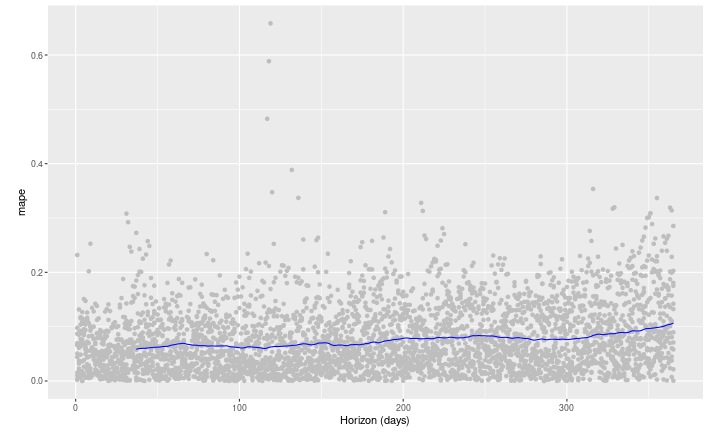

In [18]:
%%R -w 10 -h 6 -u in
plot_cross_validation_metric(df.cv, metric = 'mape')

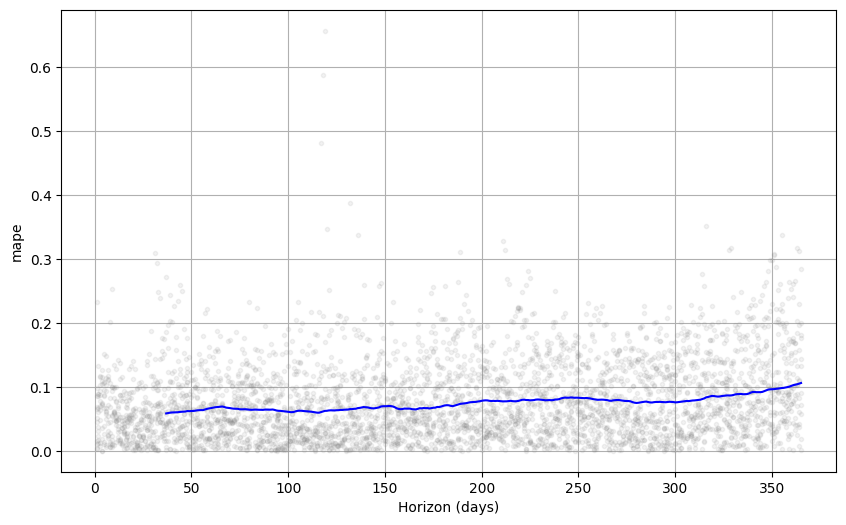

In [19]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

The size of the rolling window in the figure can be changed with the optional argument `rolling_window`, which specifies the proportion of forecasts to use in each rolling window. The default is 0.1, corresponding to 10% of rows from `df_cv` included in each window; increasing this will lead to a smoother average curve in the figure. The `initial` period should be long enough to capture all of the components of the model, in particular seasonalities and extra regressors: at least a year for yearly seasonality, at least a week for weekly seasonality, etc.


### Parallelizing cross validation

Cross-validation can also be run in parallel mode in Python, by setting specifying the `parallel` keyword. Four modes are supported

* `parallel=None` (Default, no parallelization)
* `parallel="processes"`
* `parallel="threads"`
* `parallel="dask"`

For problems that aren't too big, we recommend using `parallel="processes"`. It will achieve the highest performance when the parallel cross validation can be done on a single machine. For large problems, a [Dask](https://dask.org) cluster can be used to do the cross validation on many machines. You will need to [install Dask](https://docs.dask.org/en/latest/install.html) separately, as it will not be installed with `prophet`.


```python
from dask.distributed import Client

client = Client()  # connect to the cluster
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='365 days',
                         parallel="dask")
```

### Hyperparameter tuning

Cross-validation can be used for tuning hyperparameters of the model, such as `changepoint_prior_scale` and `seasonality_prior_scale`. A Python example is given below, with a 4x4 grid of those two parameters, with parallelization over cutoffs. Here parameters are evaluated on RMSE averaged over a 30-day horizon, but different performance metrics may be appropriate for different problems.

In [ ]:
import itertools
import numpy as np
import pandas as pd

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

19:39:23 - cmdstanpy - INFO - Chain [1] start processing
19:39:23 - cmdstanpy - INFO - Chain [1] done processing
19:39:23 - cmdstanpy - INFO - Chain [1] start processing
19:39:23 - cmdstanpy - INFO - Chain [1] start processing
19:39:23 - cmdstanpy - INFO - Chain [1] start processing
19:39:23 - cmdstanpy - INFO - Chain [1] done processing
19:39:23 - cmdstanpy - INFO - Chain [1] done processing
19:39:23 - cmdstanpy - INFO - Chain [1] done processing
19:39:24 - cmdstanpy - INFO - Chain [1] start processing
19:39:24 - cmdstanpy - INFO - Chain [1] done processing
19:39:24 - cmdstanpy - INFO - Chain [1] start processing
19:39:24 - cmdstanpy - INFO - Chain [1] start processing
19:39:24 - cmdstanpy - INFO - Chain [1] start processing
19:39:24 - cmdstanpy - INFO - Chain [1] done processing
19:39:24 - cmdstanpy - INFO - Chain [1] done processing
19:39:24 - cmdstanpy - INFO - Chain [1] done processing
19:39:25 - cmdstanpy - INFO - Chain [1] start processing
19:39:25 - cmdstanpy - INFO - Chain [1]

In [ ]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

Alternatively, parallelization could be done across parameter combinations by parallelizing the loop above.

The Prophet model has a number of input parameters that one might consider tuning. Here are some general recommendations for hyperparameter tuning that may be a good starting place.

**Parameters that can be tuned**
- `changepoint_prior_scale`: This is probably the most impactful parameter. It determines the flexibility of the trend, and in particular how much the trend changes at the trend changepoints. As described in this documentation, if it is too small, the trend will be underfit and variance that should have been modeled with trend changes will instead end up being handled with the noise term. If it is too large, the trend will overfit and in the most extreme case you can end up with the trend capturing yearly seasonality. The default of 0.05 works for many time series, but this could be tuned; a range of [0.001, 0.5] would likely be about right. Parameters like this (regularization penalties; this is effectively a lasso penalty) are often tuned on a log scale.

- `seasonality_prior_scale`: This parameter controls the flexibility of the seasonality. Similarly, a large value allows the seasonality to fit large fluctuations, a small value shrinks the magnitude of the seasonality. The default is 10., which applies basically no regularization. That is because we very rarely see overfitting here (there's inherent regularization with the fact that it is being modeled with a truncated Fourier series, so it's essentially low-pass filtered). A reasonable range for tuning it would probably be [0.01, 10]; when set to 0.01 you should find that the magnitude of seasonality is forced to be very small. This likely also makes sense on a log scale, since it is effectively an L2 penalty like in ridge regression.

- `holidays_prior_scale`: This controls flexibility to fit holiday effects. Similar to seasonality_prior_scale, it defaults to 10.0 which applies basically no regularization, since we usually have multiple observations of holidays and can do a good job of estimating their effects. This could also be tuned on a range of [0.01, 10] as with seasonality_prior_scale.

- `seasonality_mode`: Options are [`'additive'`, `'multiplicative'`]. Default is `'additive'`, but many business time series will have multiplicative seasonality. This is best identified just from looking at the time series and seeing if the magnitude of seasonal fluctuations grows with the magnitude of the time series (see the documentation here on multiplicative seasonality), but when that isn't possible, it could be tuned.

**Maybe tune?**
- `changepoint_range`: This is the proportion of the history in which the trend is allowed to change. This defaults to 0.8, 80% of the history, meaning the model will not fit any trend changes in the last 20% of the time series. This is fairly conservative, to avoid overfitting to trend changes at the very end of the time series where there isn't enough runway left to fit it well. With a human in the loop, this is something that can be identified pretty easily visually: one can pretty clearly see if the forecast is doing a bad job in the last 20%. In a fully-automated setting, it may be beneficial to be less conservative. It likely will not be possible to tune this parameter effectively with cross validation over cutoffs as described above. The ability of the model to generalize from a trend change in the last 10% of the time series will be hard to learn from looking at earlier cutoffs that may not have trend changes in the last 10%. So, this parameter is probably better not tuned, except perhaps over a large number of time series. In that setting, [0.8, 0.95] may be a reasonable range.

**Parameters that would likely not be tuned**
- `growth`: Options are 'linear' and 'logistic'. This likely will not be tuned; if there is a known saturating point and growth towards that point it will be included and the logistic trend will be used, otherwise it will be linear.

- `changepoints`: This is for manually specifying the locations of changepoints. None by default, which automatically places them.

- `n_changepoints`: This is the number of automatically placed changepoints. The default of 25 should be plenty to capture the trend changes in a typical time series (at least the type that Prophet would work well on anyway). Rather than increasing or decreasing the number of changepoints, it will likely be more effective to focus on increasing or decreasing the flexibility at those trend changes, which is done with `changepoint_prior_scale`.

- `yearly_seasonality`: By default ('auto') this will turn yearly seasonality on if there is a year of data, and off otherwise. Options are ['auto', True, False]. If there is more than a year of data, rather than trying to turn this off during HPO, it will likely be more effective to leave it on and turn down seasonal effects by tuning `seasonality_prior_scale`.

- `weekly_seasonality`: Same as for `yearly_seasonality`.

- `daily_seasonality`: Same as for `yearly_seasonality`.

- `holidays`: This is to pass in a dataframe of specified holidays. The holiday effects would be tuned with `holidays_prior_scale`.

- `mcmc_samples`: Whether or not MCMC is used will likely be determined by factors like the length of the time series and the importance of parameter uncertainty (these considerations are described in the documentation).

- `interval_width`: Prophet `predict` returns uncertainty intervals for each component, like `yhat_lower` and `yhat_upper` for the forecast `yhat`. These are computed as quantiles of the posterior predictive distribution, and `interval_width` specifies which quantiles to use. The default of 0.8 provides an 80% prediction interval. You could change that to 0.95 if you wanted a 95% interval. This will affect only the uncertainty interval, and will not change the forecast `yhat` at all and so does not need to be tuned.

- `uncertainty_samples`: The uncertainty intervals are computed as quantiles from the posterior predictive interval, and the posterior predictive interval is estimated with Monte Carlo sampling. This parameter is the number of samples to use (defaults to 1000). The running time for predict will be linear in this number. Making it smaller will increase the variance (Monte Carlo error) of the uncertainty interval, and making it larger will reduce that variance. So, if the uncertainty estimates seem jagged this could be increased to further smooth them out, but it likely will not need to be changed. As with `interval_width`, this parameter only affects the uncertainty intervals and changing it will not affect in any way the forecast `yhat`; it does not need to be tuned.